# Analyzing the Impacts of Health Services on Health Status — A Python Programming Exercise for Ordinal Response Models

<center> June, 2024 </center>

<center> 

*Yang*

 </center>

*Health status stands as a paramount indicator, reflecting an individual's comprehensive well-being and standard of living. Employing the "mus18data" dataset from the RAND Health Insurance Experiment, which ensuring exogenous insurance choice, the research examines the impacts of coinsurance services on health status. 
This research show that coinsurance rate has negative impact on health status. Specifically, it's found that one unit increase in coinsurance rate raises the probability of poor health by 0.01464%. 
Also, heterogeneity analysis reveals that the negative impact of coinsurance rate on health status is more significant among non-black populations.*

# 1 Introduction

## 1.1 Motivation

Health status is a key indicator of an individual's overall well-being and quality of life. Insurance and coinsurance are widely used to share the costs of healthcare between individuals and insurers, making them critical components of health services. By analyzing how these insurance models, specifically the structure of insurance plans and coinsurance rates, affect health status, we can identify potential barriers to accessing care and areas where improvements can be made. This can inform strategies to enhance healthcare delivery and ensure that individuals receive the necessary care to maintain and improve their health.

Also, Health disparities often arise from social determinants, including income, age, and other individual characteristics. For example, higher coinsurance rates combined with lower income levels might lead to financial barriers in seeking healthcare, influencing health outcomes. Exploring the relationship between health and some characteristics like income and age can show economic differences in healthcare access, helping identify vulnerable populations who may be disproportionately affected by high coinsurance rates or limited access to care.

## 1.2 Research Design and Dataset

This exercise aims to examine the impacts of health services on health status. The "mus18data" dataset was prepared by Deb and Trivedi (2002), from the RAND Health Insurance Experiment (RHIE), in which individuals were randomized into insurance plans, thus ensuring insurance choice exogenous. This dataset contains health status and coinsurance rate along with various individual characteristics, and will be used for this analysis. From "mus18data" dataset I choose these key variables.

- **Key dependent variable** I consider is health status that is, respectively, poor (`hlthp`=1), fair (`hlthf`=1), or good (`hlthg`=1). And I will transfer them to one variable `health` takes 3 possible ordinal values $\{0, 1, 2\}$ which respectively represent the health status of the individual is: poor, fair, and good.
- **Key independent variables** I choose to focus on is `coins` (coinsurance rate). For example, a coinsurance rate of 25% means that the insured pays 25% and the insurer pays 75%.
- Also, a series of covariates are also considered: `age`,  `linc` (log of annual family income in $), and so on.

The independent variables that I am focusing on may have potential policy implications. For example, if the study reveals that higher coinsurance rates are associated with poorer health outcomes, policymakers might consider regulations to cap coinsurance rates or provide subsidies to ensure that individuals can afford necessary healthcare. This analysis could help in designing health insurance policies that balance cost-sharing while ensuring adequate access to healthcare services.





## 1.3 Econometric Methods

Regarding the econometric method, I employ the ordinal probit regression. Using the ordinal response model, one can estimate the probability of the health status. The model can be formulated as

$$\Pr(health_i=j|\boldsymbol{x}_i)=\Phi(\mu_{j} -\boldsymbol{x}_i'\boldsymbol{\beta}) -\Phi(\mu_{j-1} -\boldsymbol{x}_i'\boldsymbol{\beta})$$

for any $i\in\{1,\ldots,n\}$ and $j\in\{0, 1, 2\}$, where

- $\beta'x_i = \beta_1coins_i + \beta_2age_i + \beta_3linc_i + \beta_4num_i + \beta_5ldrugdol_i$,
- $\Phi(\cdot)$ is the CDF function of the standard normal distribution,
- and $\mu = (\mu_{-1}, \ldots, \mu_2)$ refers to the cutoff points.

Additionally, for econometric identification, the smallest and largest cutoff points are anchored at $-\infty$ and $\infty$. These adjustments will be taken into account when implementing the maximum likelihood estimation (MLE) in Python.

The probit model is often preferred in economic research due to its basic assumption that the error terms follow a normal distribution, which aligns well with many economic theories. This makes it a robust choice for analyzing ordinal data in economic studies.

In addition to estimating the basical model parameters, I will calculate the marginal effects using Python-Stata interaction, yielding meaningful economic interpretations. Moreover, I will conduct heterogeneity analysis across different ethnic groups and evaluate the predictive performance of the model using machine learning techniques. These additional analyses will provide deeper insights into the data and enhance the overall significance of the findings.

The subsequent sections of this research will be structured as follows: 

- In the second part, I will perform data cleaning to ensure the dataset is accurate and ready for analysis. 
- In the third part, I will involve descriptive analysis and visualization to provide an overview of the data. 
- In the fourth part, I will conduct the econometric analysis to examine the impacts of coinsurance rates on health status. 
- Finally, the fifth part will present the conclusions drawn from the research, summarizing the key findings and their implications.

# 2 Data Cleaning

As the raw dataset is stored in `.dta` format, which is a data file format used by Stata, I imported it through pandas. For data
cleaning, I started by taking logs on drugdol and address missing values out of the dataset, then winsorize continuous variables to mitigate the influence of extreme values.


In [ ]:
import pandas as pd
import numpy as np

data_path='C:\\Users\\mus18data.dta'
data=pd.read_stata(data_path)

# ln(drugdol)
data['drugdol'] = data['drugdol'].apply(lambda x: x if x > 0 else np.nan)
data['ldrugdol'] = np.log(data['drugdol'])

# drop missing values
data = data.dropna()
data = data[(data['hlthp'] != 0) | (data['hlthf'] != 0) | (data['hlthg'] != 0)]

# transfer to variable 'health'
data['health'] = 0
data.loc[data['hlthp'] == 1, 'health'] = 0  # poor
data.loc[data['hlthf'] == 1, 'health'] = 1  # fair
data.loc[data['hlthg'] == 1, 'health'] = 2  # good

# winsorize continuous variables at 1% and 99%
continuous_vars = ['age', 'linc', 'num', 'ldrugdol']
for var in continuous_vars:
    lower_bound = data[var].quantile(0.01)
    upper_bound = data[var].quantile(0.99)
    data[var] = data[var].clip(lower=lower_bound, upper=upper_bound)


print(data.head().to_string(max_rows=None, line_width=70, col_space=5, justify='left', show_dimensions=True))


       plan  site  coins  tookphys  year  id        black  \
4470   15.0  2.0   95.0   1.0       1.0   225021.0  0.0     
4471   15.0  2.0   95.0   1.0       2.0   225021.0  0.0     
4472   15.0  2.0   95.0   1.0       3.0   225021.0  0.0     
4478   11.0  2.0    0.0   1.0       1.0   225023.0  0.0     
4480   11.0  2.0    0.0   1.0       3.0   225023.0  0.0     

       income      age        female  educdec  time  outpdol     \
4470   4848.09375  23.334702  1.0     16.0     1.0    19.807280   
4471   4848.09375  24.334702  1.0     16.0     1.0    41.483650   
4472   4848.09375  25.334702  1.0     16.0     1.0     6.775068   
4478   9751.90625  28.043806  1.0     12.0     1.0   101.809471   
4480   9751.90625  30.043806  1.0     12.0     1.0   404.177887   

       drugdol    suppdol  mentdol  inpdol  med         totadm  \
4470    6.183084  0.0      0.0      0.0      25.990364  0.0      
4471   32.757442  0.0      0.0      0.0      74.241096  0.0      
4472    0.953026  0.0      0.0  

# 3 Descriptive Analysis
## 3.1 Summary Statistics and Distribution

By performing both summary statistics and visualization, we can identify distributions of the variables in the data, which will be crucial for the subsequent econometric analysis. Firstly, the table of summary statistics is produced by the next command.

In [21]:
print(data.describe().to_string(max_rows=None, line_width=70, col_space=5, justify='left', show_dimensions=True))

       plan         site         coins        tookphys     \
count  3804.000000  3804.000000  3804.000000  3804.000000   
mean     12.402734     4.002366    18.328075     0.682965   
std       2.948636     1.533994    31.678093     0.465382   
min       5.000000     2.000000     0.000000     0.000000   
25%      11.000000     2.000000     0.000000     0.000000   
50%      11.000000     4.000000     0.000000     1.000000   
75%      13.000000     6.000000    25.000000     1.000000   
max      19.000000     6.000000    95.000000     1.000000   

       year        id             black        income        \
count  3804.00000    3804.000000  3804.000000   3804.000000   
mean      2.32387  428275.968750     0.172615   7585.403809   
std       1.18197  153778.578125     0.375730   3949.431641   
min       1.00000  225021.000000     0.000000      0.000000   
25%       1.00000  231518.500000     0.000000   4859.824219   
50%       2.00000  427613.500000     0.000000   7400.000000   
75%      

To gain a deeper insight into the data, I visualize the distribution of key variables. The following plots will be created.

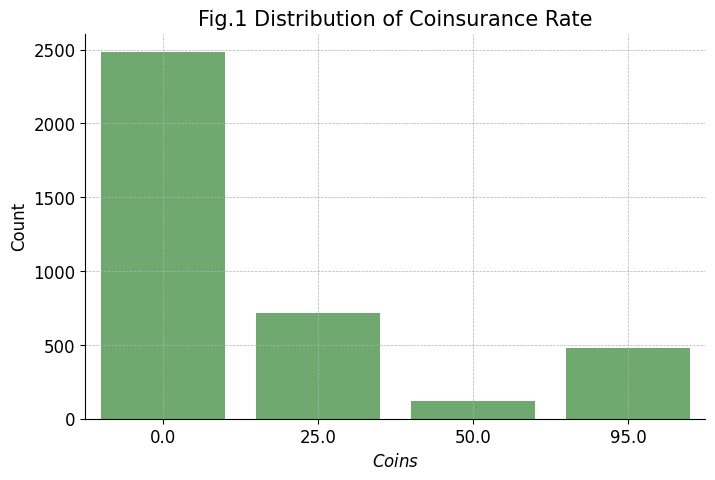

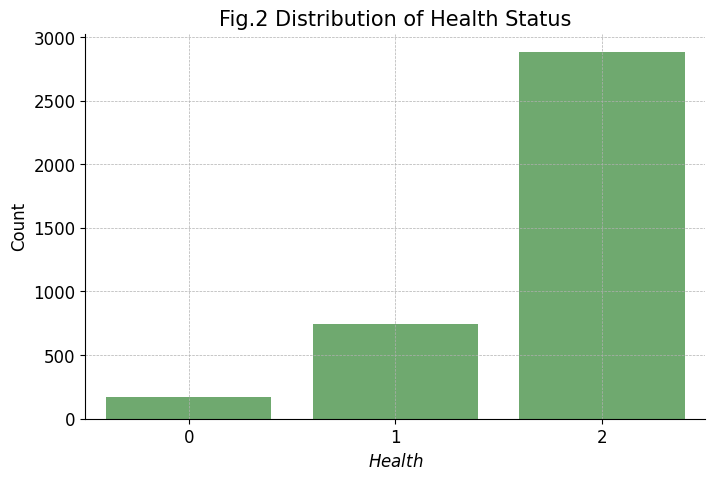

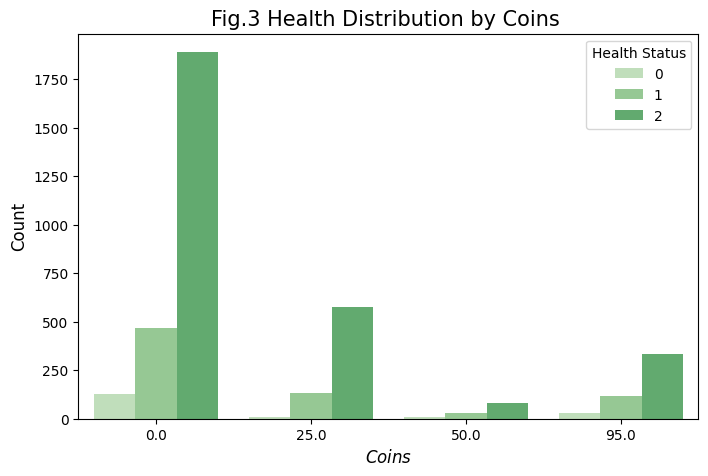

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# bar chart: display the distribution of coins
plt.figure(figsize=(8,5))
sns.countplot(x='coins', data=data, alpha=0.6, color='green')
plt.title('Fig.1 Distribution of Coinsurance Rate', fontsize=15)
plt.xlabel(r'$Coins$', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=False, bottom=False)
plt.show()

# bar chart: display the distribution of health
plt.figure(figsize=(8, 5))
sns.countplot(x='health', data=data, alpha=0.6, color='green')
plt.title('Fig.2 Distribution of Health Status', fontsize=15)
plt.xlabel(r'$Health$', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(left=False, bottom=False)
plt.show()

# Grouped bar chart: display the distribution of health by coins
custom_palette = sns.color_palette('Greens', n_colors=6)[1:4]
plt.figure(figsize=(8, 5))
sns.countplot(x='coins', hue='health', data=data, palette=custom_palette)
plt.title('Fig.3 Health Distribution by Coins ', fontsize=15)
plt.xlabel(r'$Coins$', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Health Status')
plt.show()

The above three plots (Figs. 1, 2, and 3) provide a comprehensive overview of the distribution of coinsurance rates and health status in the dataset, as well as the relationship between these two key variables.

- **Coinsurance Rate Distribution**: The majority of participants have low or no coinsurance rates, indicating a possible preference or access to plans with minimal out-of-pocket costs.

- **Health Status Distribution**: Most participants report good health, suggesting a generally healthy population in the dataset.

- **Relationship Between Coinsurance Rate and Health Status**: There is an observable trend that higher coinsurance rates are associated with worse health outcomes. This supports the hypothesis that higher coinsurance rates may negatively impact health by discouraging the use of healthcare services.


Furthermore, I present the distribution of covariates under different health status conditions.

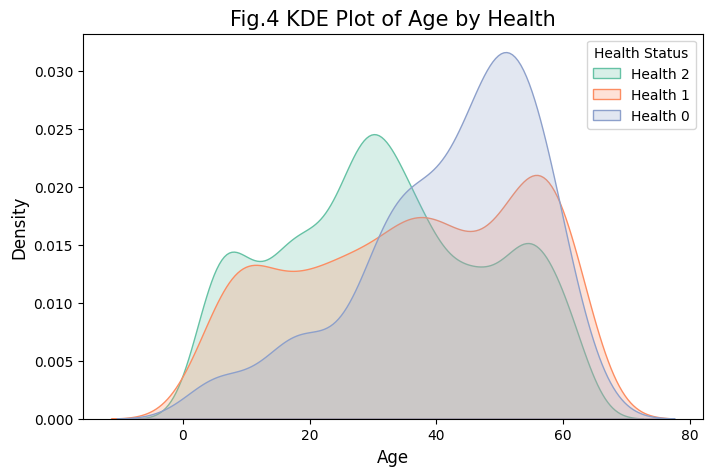

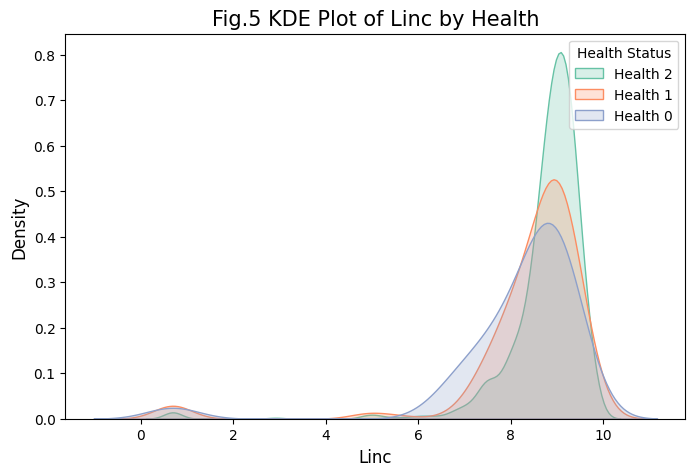

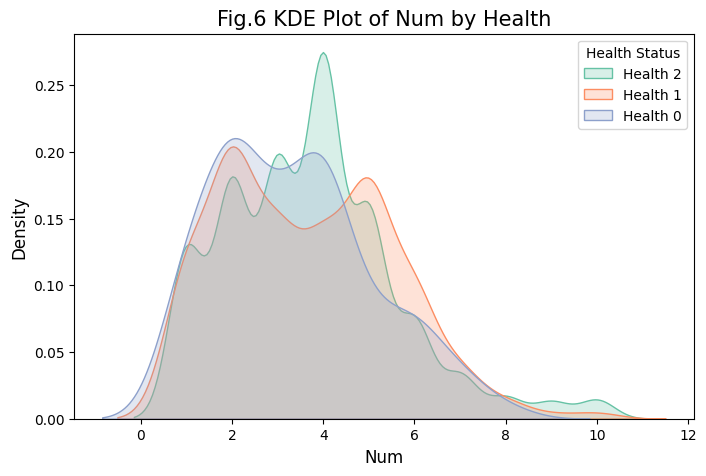

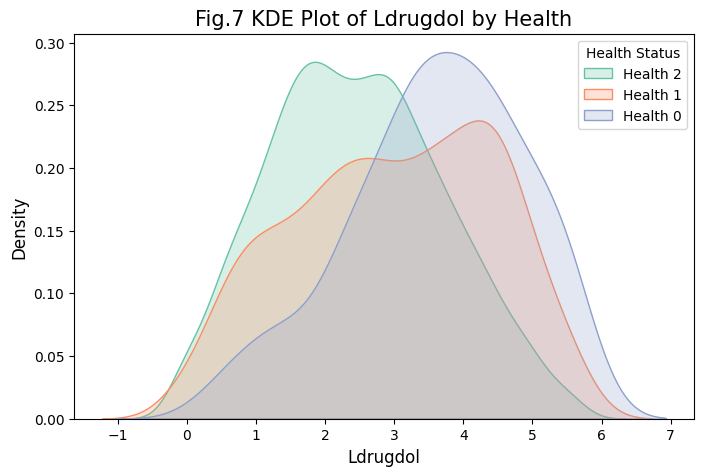

In [23]:
variables_to_plot = ['age', 'linc', 'num', 'ldrugdol']
palette = sns.color_palette("Set2", len(data['health'].unique()))

# plot kernel density estimation for each variable
for idx, var in enumerate(variables_to_plot):
    plt.figure(figsize=(8, 5))
    for i, health_status in enumerate(data['health'].unique()):
        subset = data[data['health'] == health_status]
        sns.kdeplot(subset[var], label=f'Health {health_status}', color=palette[i], fill=True)
    plt.title(f'Fig.{idx + 4} KDE Plot of {var.capitalize()} by Health', fontsize=15)
    plt.xlabel(var.capitalize(), fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='Health Status')
    plt.show()

- Images Fig.4 to Fig.7 show Kernel Density Estimation (KDE) plots for four variables (`age`, `linc`, `num`, `ldrugdol`) for different health states (health). These plots help us to understand the distribution of these variables in different health states.

These KDE plots collectively highlight significant differences in the distributions of age, income, the number of children, and drug expenditures across health statuses. Younger age, higher family income, smaller number of children, and lower drug expenditures are associated with better health status, providing a foundational understanding of the data and set the stage for deeper econometric analysis to further explore these relationships and their implications.

## 3.2 Correlation Between Key Variables

Understanding the correlation between key variables, such as health status and coinsurance rate, is crucial for identifying their relationships. Since discrete variables are not suitable for scatter plots, I chose to create a heatmap to illustrate the relationship between health and coins. 

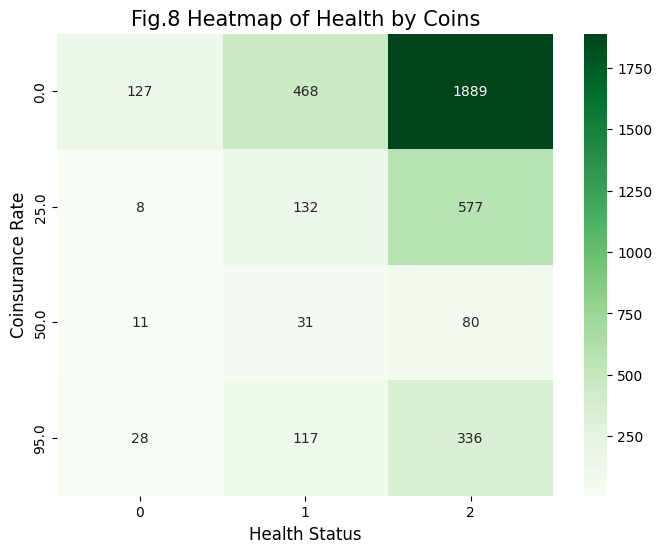

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# organize data into a format suitable for plotting a heatmap
pivot_data = data.pivot_table(index='coins', columns='health', aggfunc='size')

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='Greens', fmt='g')
plt.title('Fig.8 Heatmap of Health by Coins', fontsize=15)
plt.xlabel('Health Status', fontsize=12)
plt.ylabel('Coinsurance Rate', fontsize=12)
plt.show()

Further, I used a 3D surface plot to illustrate the relationship among age, health status, and coinsurance rate, with ChatGPT as my assistant. Such multi-dimensional analysis shows more complex relationships that helps identifying potential interaction. And it's easy to see that the largest samples are concentrated in high health status with low coinsurance rates

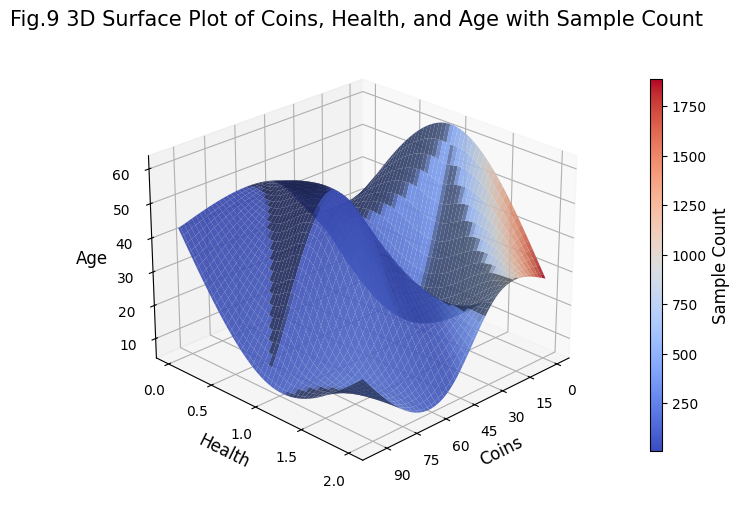

In [25]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.ticker as ticker

# calculate the sample count for each coins and health
aggregated_data = data.groupby(['coins', 'health']).size().reset_index(name='count')

# create grid data for frequency calculation
grid_x, grid_y = np.mgrid[aggregated_data['coins'].min():aggregated_data['coins'].max():100j,
                          aggregated_data['health'].min():aggregated_data['health'].max():100j]
grid_z_count = griddata((aggregated_data['coins'], aggregated_data['health']), aggregated_data['count'], (grid_x, grid_y), method='linear')
grid_z_num = griddata((data['coins'], data['health']), data['age'], (grid_x, grid_y), method='cubic')

# 3D surface plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(grid_x, grid_y, grid_z_num, facecolors=plt.cm.coolwarm(grid_z_count / grid_z_count.max()), edgecolor='none',alpha=0.9)
mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm)
mappable.set_array(grid_z_count)
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, fraction=0.02, aspect=30)
cbar.set_label('Sample Count', fontsize=12)
ax.set_title('Fig.9 3D Surface Plot of Coins, Health, and Age with Sample Count', fontsize=15)
ax.set_xlabel('Coins', fontsize=12)
ax.set_ylabel('Health', fontsize=12)
ax.set_zlabel('Age', fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.zaxis.set_major_locator(ticker.MultipleLocator(10))

# rotate the plot
ax.view_init(elev=25, azim=45)
plt.show()

# 4 Econometric Analysis

## 4.1 Using statsmodels Commands

Based on the econometric methods mentioned in the first part, I first use `statsmodels` to estimate the parameters of the ordinal probit model.

In [26]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

X = data[['coins', 'age', 'linc', 'num', 'ldrugdol']]
y = data['health']

# ordered Probit model
model_probit = OrderedModel(y, X, distr='probit')

# fit the model
result_probit = model_probit.fit(method='bfgs')

print(result_probit.summary())

Optimization terminated successfully.
         Current function value: 0.628659
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:                 health   Log-Likelihood:                -2391.4
Model:                   OrderedModel   AIC:                             4797.
Method:            Maximum Likelihood   BIC:                             4841.
Date:                Tue, 25 Jun 2024                                         
Time:                        16:42:23                                         
No. Observations:                3804                                         
Df Residuals:                    3797                                         
Df Model:                           5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [27]:
cut_off_points = model_probit.transform_threshold_params(result_probit.params)
print(cut_off_points)

[       -inf -1.32292571 -0.24643241         inf]


Based on the estimation, I would draw the following conclusions:

- All explanatory variables are statistically significant, showing that these variables have a meaningful impact on health status.

- Especially for coinsurance rates, the negative coefficient of -0.0019 for `coins` indicates that higher coinsurance rates would lead to a decreased likelihood of better health status.
- Also can be seen from the table, `age`, `num`, `ldrugdol` all have a negative effect on health status, while `linc` has a positive effect on health status.
  
In the probit model, the coefficients from the direct regression are not economically meaningful, but we can derive more meaningful coefficients by calculating the marginal effect.

## 4.2 Marginal Effect

In the ordered models, there are now more than two outcomes and have _a set of marginal effects_ on the probabilities of $health_i$ being different values, i.e., $\Pr(health_i=0|\boldsymbol{coins}_i),...,\Pr(health_i=m|\boldsymbol{coins}_i)$\. 

It's need to compute
$$\frac{\partial \Pr(health=j|coins)}{\partial  coins} = \phi(\beta coins - \mu_{j-1}) \beta - \phi(\beta coins - \mu_{j}) \beta$$
for $j=0,1,2$. Note that when $j=0$ or $2$, above equation reduces to 
$$ - \phi(\beta coins - \mu_0) \beta  \text{ and } \phi(\beta coins - \mu_1) \beta - \phi(\beta coins - \mu_2) \beta$$ 
respectively. 

And it can be easy to computed these effects by calling Stata from Python, for example:

In [28]:
# Python-Stata interaction
import os
os.chdir('E:\\STATA\\Stata17\\utilities')
from pystata import config
config.init('mp')

# Transfer data to Stata
from pystata import stata

stata.pdataframe_to_data(data, force=True)

# regress and compute the marginal effect
stata.run(
    '''quietly oprobit health coins age linc num ldrugdol
    mfx''')


. quietly oprobit health coins age linc num ldrugdol

.     mfx

Marginal effects after oprobit
      y  = Pr(health==0) (predict)
         =  .03438405
------------------------------------------------------------------------------
variable |      dy/dx    Std. err.     z    P>|z|  [    95% C.I.   ]      X
---------+--------------------------------------------------------------------
   coins |   .0001464      .00005    2.82   0.005   .000045  .000248   18.3281
     age |   .0006314      .00012    5.25   0.000   .000396  .000867   33.1862
    linc |  -.0132959      .00149   -8.94   0.000  -.016212  -.01038   8.66097
     num |   .0034563      .00098    3.54   0.000   .001542  .005371   3.68612
ldrugdol |   .0156333      .00161    9.69   0.000    .01247  .018796   2.61825
------------------------------------------------------------------------------

. 


For coinsurance rates, the marginal effect is 0.0001464, which means that the probability of health status being poor (`health`=0) increases by 0.01464% for a 1 unit increase in `coins`

## 4.3 Bootstrap Resampling

Then I will use bootstrap estimator and conduct the inference, as bootstrapping is a powerful statistical technique used to estimate the sampling distribution of an estimator by resampling with replacement from the original data. And we could see from the table below that negative effect of `coins` is robust.

In [29]:
from sklearn.utils import resample
import numpy as np
from scipy import stats

np.random.seed(2024)

def bootstrap_model(n_iterations):
    coefs = []
    for _ in range(n_iterations):
        # Bootstrap resample
        X_boot, y_boot = resample(X, y)
        model = OrderedModel(y_boot, X_boot, distr='probit')
        result = model.fit(method='bfgs', disp=False)
        coefs.append(result.params[:len(X.columns)]) 
    coefs = np.array(coefs)
    return coefs

# calculate key statistics from bootstrap samples
bootstrap_coefs = bootstrap_model(100)
coef_means = bootstrap_coefs.mean(axis=0)
coef_se = bootstrap_coefs.std(axis=0)
ci_lower = np.percentile(bootstrap_coefs, 5, axis=0)
ci_upper = np.percentile(bootstrap_coefs, 95, axis=0)

# print in table
num_params = len(coef_means)
report = np.zeros((num_params, 6), dtype=float)
report[:, 0] = coef_means.round(4)
report[:, 1] = coef_se.round(4)
report[:, 2] = (coef_means / coef_se).round(3)
report[:, 3] = (2 * (1 - stats.norm.cdf(np.abs(coef_means / coef_se)))).round(4)
report[:, 4] = ci_lower.round(4)
report[:, 5] = ci_upper.round(4)
index_labels = X.columns.tolist()
report_df = pd.DataFrame(report, index=index_labels, columns=['Estimate', 'Std. Err.', 'z-stat', 'p-value', '90% CI Lower', '90% CI Upper'])    
print("Bootstrap Estimates")
print(report_df)

Bootstrap Estimates
          Estimate  Std. Err.  z-stat  p-value  90% CI Lower  90% CI Upper
coins      -0.0019     0.0007  -2.691   0.0071       -0.0030       -0.0006
age        -0.0081     0.0014  -5.606   0.0000       -0.0107       -0.0058
linc        0.1740     0.0149  11.679   0.0000        0.1492        0.1972
num        -0.0450     0.0127  -3.547   0.0004       -0.0635       -0.0247
ldrugdol   -0.2073     0.0192 -10.811   0.0000       -0.2397       -0.1764


## 4.4 Codifying the MLE Manually in Python

Next, I manually try to code the log\-likelihood and apply SciPy's optimization routine. We could see from the result similar to the statsmodels commands that coinsurance rates negatively impact health status. The log\-likelihood function is

$${l}({\beta}, \boldsymbol{\mu}| \boldsymbol{health},\boldsymbol{X}) = \sum_{i=1}^n \sum_{j=0}^2 \ln\bigg (\Pr(health_i=j|\boldsymbol{x}_i, \boldsymbol{\beta}, \boldsymbol{\mu}) \bigg).$$


In [30]:
from scipy.optimize import minimize
import scipy.stats as stats
import numpy as np

class Ordermodel:
    def __init__(self, f, miu_size, y, x, x0):
        self.f = f
        self.miu_size = miu_size
        self.y = y
        self.x = x
        self.model = 'oprobit'
        self.m = len(np.unique(self.y))
        self.x0 = x0
        # columns of x
        if self.x.ndim == 1:
            self.k = 1
        else:
            self.k = np.shape(self.x)[1]
    
    # define the model estimation function
    def minimizing(self):
        self.result = minimize(self.f, x0=self.x0, args=(self.m, self.x, self.y, self.k, self.model))
        return self.result
    
    # define the table function
    def table(self):
        self.report = np.zeros((self.k+self.miu_size, 6), dtype=float)
        self.report[:,0] = (self.result.x).round(4)
        result_se = np.sqrt(np.diag(self.result.hess_inv))
        self.report[:,1] = (result_se).round(4)
        self.report[:,2] = (self.result.x/result_se).round(3)
        self.report[:, 3] = (2 * (1 - stats.norm.cdf(np.abs(self.result.x / result_se)))).round(4) 
        self.report[:,4] = (self.result.x - 1.96*result_se/np.sqrt(np.shape(self.x)[0])).round(4)
        self.report[:,5] = (self.result.x + 1.96*result_se/np.sqrt(np.shape(self.x)[0])).round(4)
        index_labels = self.x.columns.tolist() + ['threshold_1', 'threshold_2']
        self.Report = pd.DataFrame(self.report, index=index_labels, columns=['Parameter', 'Std. Err.', 'z-stat', 'p-value', 'Lower CI', 'Upper CI'])
        return self.Report
    
# define the ordered function
def ofunction(theta, m, x, y, k, model='oprobit'):
    beta = theta[0:k]
    if k == 1: 
        BX = x * beta
    else:
        BX = x @ beta
    # Mu (vectorized)
    mu = theta[k:]
    mu = np.append(np.append(-np.inf,mu),np.inf)
    # calculate probit model
    output = 0
    for j in range(m):
            output = output + np.sum((y==j)*np.log(stats.norm.cdf(mu[j+1]-BX)-stats.norm.cdf(mu[j]-BX)+1e-20))
    return -output


initial_params = np.zeros(X.shape[1] + 2) 
initial_params[-2:] = [0,1] 

# ordinal probit model
order_model = Ordermodel(f=ofunction, miu_size=2, y=y, x=X, x0=initial_params)

# estimate
result = order_model.minimizing()

# print table
report = order_model.table()
print("Table: Manually Ordered Probit Model Parameter Estimation Results:")
print(report)

Table: Manually Ordered Probit Model Parameter Estimation Results:
             Parameter  Std. Err.  z-stat  p-value  Lower CI  Upper CI
coins          -0.0019     0.0007  -2.857   0.0043   -0.0019   -0.0019
age            -0.0083     0.0015  -5.559   0.0000   -0.0083   -0.0082
linc            0.1746     0.0164  10.626   0.0000    0.1741    0.1751
num            -0.0454     0.0124  -3.667   0.0002   -0.0458   -0.0450
ldrugdol       -0.2053     0.0178 -11.532   0.0000   -0.2059   -0.2047
threshold_1    -1.3229     0.1540  -8.592   0.0000   -1.3278   -1.3180
threshold_2    -0.2464     0.1501  -1.642   0.1005   -0.2512   -0.2417


## 4.5 Heterogeneity Analysis

Further, I investigate whether the effect of `coins` on `health` varies across different racial groups.

In [31]:
data['female_coins'] = data['female'] * data['coins']
data['black_coins'] = data['black'] * data['coins']

# black group
black_data = data[data['black'] == 1]
X_black = black_data[['coins', 'age', 'linc', 'num', 'drugdol']]
y_black = black_data['health']

model_female = OrderedModel(y_black, X_black, distr='probit')
result_female = model_female.fit(method='bfgs')

print("Black group")
print(result_female.summary())

Optimization terminated successfully.
         Current function value: 0.732314
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22
Black group
                             OrderedModel Results                             
Dep. Variable:                 health   Log-Likelihood:                -471.61
Model:                   OrderedModel   AIC:                             957.2
Method:            Maximum Likelihood   BIC:                             988.5
Date:                Tue, 25 Jun 2024                                         
Time:                        16:42:47                                         
No. Observations:                 644                                         
Df Residuals:                     637                                         
Df Model:                           5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

In [32]:
# non-black group
nonblack_data = data[data['black'] == 0]
X_nonblack = nonblack_data[['coins', 'age', 'linc', 'num', 'drugdol']]
y_nonblack = nonblack_data['health']

model_male = OrderedModel(y_nonblack, X_nonblack, distr='probit')
result_male = model_male.fit(method='bfgs')

print("Non-black group")
print(result_male.summary())

Optimization terminated successfully.
         Current function value: 0.591732
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
Non-black group
                             OrderedModel Results                             
Dep. Variable:                 health   Log-Likelihood:                -1851.5
Model:                   OrderedModel   AIC:                             3717.
Method:            Maximum Likelihood   BIC:                             3759.
Date:                Tue, 25 Jun 2024                                         
Time:                        16:42:48                                         
No. Observations:                3129                                         
Df Residuals:                    3122                                         
Df Model:                           5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

We can find that the negative effect of `coins` (Coinsurance Rate) on `health` (Health Status) is more significant in the non-black group and not significant in the black group. This may because of the relatively low average income of black households. Thus, the financial burden of the self-payment portion of the bill may be very stressful for them even if insurance covers a portion of the cost, preventing health insurance effect from blacks.

## 4.6 Forecasting based on Random Forest

In the previous sections, I conducted causal inference to determine the effect of `coins` on `health`. Next, I attempt to evaluate the predictability of the model based on Random Forest. By averaging the results of many decision trees, Random Forest can capture complex, non-linear relationships and achieves high accuracy. Also, it could show the importance of each feature in predictions, helping in understanding which factors are most influential.

              precision    recall  f1-score   support

           0       0.76      0.32      0.45        41
           1       0.83      0.50      0.62       159
           2       0.85      0.99      0.91       561

    accuracy                           0.85       761
   macro avg       0.82      0.60      0.66       761
weighted avg       0.84      0.85      0.83       761

Accuracy: 0.8475689881734559


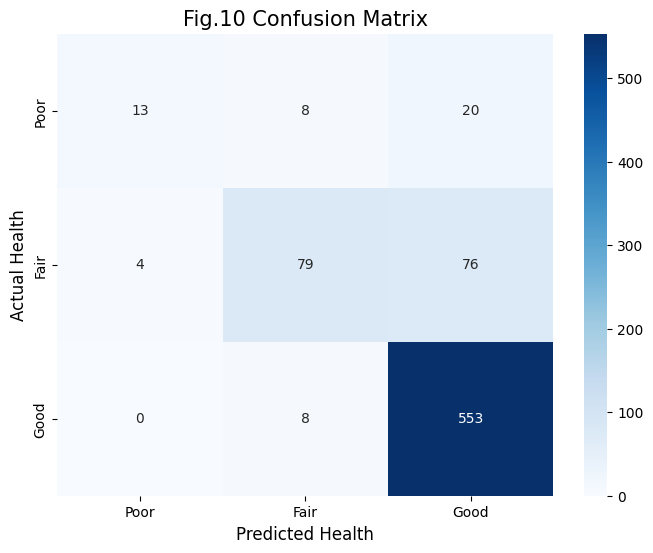

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022102761)

# initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=2022102761)

# train and predict
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# visualize confusion matrix to show the accuracy
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Poor', 'Fair', 'Good'], yticklabels=['Poor', 'Fair', 'Good'])
plt.title('Fig.10 Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Health', fontsize=12)
plt.ylabel('Actual Health', fontsize=12)
plt.show()

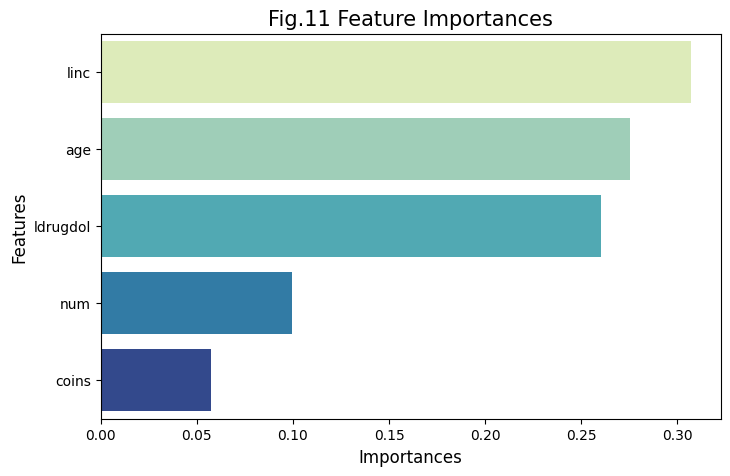

In [35]:
import warnings 

# calculate feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', palette='YlGnBu', data=feature_importance_df)
plt.title('Fig.11 Feature Importances', fontsize=15)
plt.ylabel('Features', fontsize=12)
plt.xlabel('Importances', fontsize=12)
plt.show()
warnings.filterwarnings('ignore')

- Fig.10, the confusion matrix indicates that the model performs well in predicting the "Good" health status, as evidenced by the high count of correct predictions (553), but it struggles more between "Poor" and "Fair" health status, as indicated by the higher misclassification rates in these categories.
  
- Fig.11, the feature importance plot shows that family income, age, and drug expenditures are the most influential factors in predicting health status, while coinsurance rate being the least influential among the included features.

It also shows a key distinction between economics research and other data analysis. As popular data analysis algorithms in statistics and econometrics can be classified according to prediction and causal inference, economic research places a greater emphasis on causal inference, while other fields may prioritize predictive accuracy and metrics like R-squared.

# 5 Conclusions

In conclusion, the econometric analysis leads to several key insights regarding the factors influencing health status.

- Firstly, it's found that the coinsurance rate (`coins`), age (`age`), the number of children (`num`), and the expenditure on drugs (`ldrugdol`) have a negative impact on `health`. Specifically, for the marginal effects, the probability of having poor health status (`health`=0) increases by 0.01464% for a 1 unit increase in `coins`. This indicates that higher coinsurance rates, older age, a higher number of children, and greater drug expenditures are associated with poorer health outcomes. Conversely, income (`linc`) has a positive impact on health, suggesting that higher income levels are linked to better health status. To ensure the reliability of the results, I utilized the bootstrap method and found that conclusions are robust and consistent, providing strong evidence for the observed relationships.

- Secondly, further heterogeneity analysis revealed significant demographic differences in the impact of coins on health. Specifically, the negative impact of coins on health is more significant among non-black populations. It suggests that the burden of higher coinsurance rates may disproportionately affect certain groups, thereby necessitating targeted interventions to address these disparities.

- Lastly, by employing a random forest model, we were able to assess the predictive performance of the model. The model demonstrated good prediction performance, confirming the validity of the approach. However, it is noteworthy that coins ranked last in feature importance within the model. This implies that while coins has a statistically significant negative impact on health, its relative importance compared to other factors is lower. 

These insights can inform policy decisions aimed at improving health outcomes and reducing health disparities across different population groups. Ultimately, the findings underscore the complexity of health determinants and the necessity of employing robust, multifaceted analytical approaches to inform effective health policy and interventions. In the future, exploring the mechanisms through which the coinsurance service actually influences health status may provide additional insights into the research.

